In [1]:
import sys
path = 'C:/Users/hane0/Desktop/금공 수업/4학년2학기/계산금융' # TDMAsolver의 위치
sys.path.append(path)

In [2]:
#################### Parameters ####################
sig1, sig2 = 0.25, 0.3 # return volatility of Asset 1 and 2
r = 0.05 # risk-free interest rate
rho = 0.5 # correlation
T = 1 # time-to-maturity

K0 = 100 # reference price
L = 300 # boundary of truncated computational domain of prices of Asset 1 and 2 (assumed to be the same)(그냥 충분히 큰 값)
F=100 #Face Value
mean1,mean2=0.1,0.1
Nt, Nx, Ny = 360,100,100 # number of grid points in tau-, x-, y-directions
dt, h = T/Nt,L/Nx   # time step, space step
D=60 #knock-in barrier level
d=0.16 #dummy rate
ex_p=[0.9,0.85,0.8,0.75] #Exercise price rate : ex_p*K
ror=[0.055,0.11,0.165,0.22]
n_monte=20000 #number of Monte Carlo Situation

In [3]:
T/Nt

0.002777777777777778

In [4]:
#################### Choose a method: ADI or OS ####################
method = 'ADI'

In [5]:
#################### Cell-centered discretization (ghost points included) ####################
import numpy as np
x = np.linspace(-0.5*h, L + 0.5*h, Nx + 2)
y = np.linspace(-0.5*h, L + 0.5*h, Ny + 2)

In [6]:
print(x)

[ -1.5   1.5   4.5   7.5  10.5  13.5  16.5  19.5  22.5  25.5  28.5  31.5
  34.5  37.5  40.5  43.5  46.5  49.5  52.5  55.5  58.5  61.5  64.5  67.5
  70.5  73.5  76.5  79.5  82.5  85.5  88.5  91.5  94.5  97.5 100.5 103.5
 106.5 109.5 112.5 115.5 118.5 121.5 124.5 127.5 130.5 133.5 136.5 139.5
 142.5 145.5 148.5 151.5 154.5 157.5 160.5 163.5 166.5 169.5 172.5 175.5
 178.5 181.5 184.5 187.5 190.5 193.5 196.5 199.5 202.5 205.5 208.5 211.5
 214.5 217.5 220.5 223.5 226.5 229.5 232.5 235.5 238.5 241.5 244.5 247.5
 250.5 253.5 256.5 259.5 262.5 265.5 268.5 271.5 274.5 277.5 280.5 283.5
 286.5 289.5 292.5 295.5 298.5 301.5]


In [7]:
#################### Pre-allocation ####################
# u:knock-in event 발생
# v:knock-in event 발생X
u, u2 = np.zeros(shape=(Nx+2, Ny+2)), np.zeros(shape=(Nx+2, Ny+2)) #초기값 u, step1을 지난 것을 u2, step2가 끝나면 다시 u에 집어넣어. 이런 거 for문으로 반복하면 결국은 u에 들어가게 됨
v, v2 = np.zeros(shape=(Nx+2, Ny+2)), np.zeros(shape=(Nx+2, Ny+2))
f, g = np.zeros(shape=Nx), np.zeros(shape=Ny)
a_x, b_x, c_x = np.zeros(shape=Nx), np.zeros(shape=Nx), np.zeros(shape=Nx)#알파/베타/감마
a_y, b_y, c_y = np.zeros(shape=Ny), np.zeros(shape=Ny), np.zeros(shape=Ny)

In [8]:
dt

0.002777777777777778

In [9]:
#################### Coefficients of x (for the first step of the ADI/OS algorithm) ####################
for i in range(Nx):
    a_x[i] = -(sig1*x[i+1])**2/(2*h**2)
    c_x[i] = -(sig1*x[i+1])**2/(2*h**2) - r*x[i+1]/h
    if method == 'ADI':
        b_x[i] = 2/dt + (sig1*x[i+1])**2/(h**2) + r*x[i+1]/h + r
    elif method == 'OS':
        b_x[i] = 1/dt + (sig1*x[i+1])**2/(h**2) + r*x[i+1]/h + r/2
    else:
        raise ValueError
# 이렇게 for문 밖에서 결정하는게 더 효율적

# Adjustment of the coefficients
b_x[0] += 2*a_x[0]
c_x[0] -= a_x[0]
a_x[-1] -= c_x[-1]
b_x[-1] += 2*c_x[-1]

In [326]:
#################### Coefficients of y (for the second step of the ADI/OS algorithm) ####################
for j in range(Ny):
    a_y[j] = -(sig2*y[j+1])**2/(2*h**2)
    
    
    c_y[j] = -(sig2*y[j+1])**2/(2*h**2) - r*y[j+1]/h
    if method == 'ADI':
        b_y[j] = 2/dt + (sig2*y[j+1])**2/(h**2) + r*y[j+1]/h + r
    elif method == 'OS':
        b_y[j] = 1/dt + (sig2*y[j+1])**2/(h**2) + r*y[j+1]/h + r/2
    else:
        raise ValueError

# Adjustment of the coefficients
b_y[0] += 2 * a_y[0]
c_y[0] -= a_y[0]
a_y[-1] -= c_y[-1]
b_y[-1] += 2 * c_y[-1]

In [327]:
ror[3]

0.22

In [328]:
#################### Initial condition for ELS ####################

# 1) knock-in case (u)
for i in range(len(x)):
    for j in range(len(y)):
        ST=min(x[i],y[j])
        if x[i]>=ex_p[3]*K0 and y[j]>=ex_p[3]*K0:
            u[i,j]=(1+ror[3])*F
        else:
            u[i,j]=(ST/K0)*F

# 2) No Knock-in case (v)
for i in range(len(x)):
    for j in range(len(y)):
        ST=min(x[i],y[j])
        if x[i]>=D and y[j]>=D:
            if x[i]>=ex_p[3]*K0 and y[j]>=ex_p[3]*K0:
                v[i,j]=(1+ror[3])*F
            else:
                v[i,j]=(1+d)*F
        else:
            v[i,j]=(ST/K0)*F

In [329]:
#################### Linear boundary condition ####################

u[0, 1:-1] = 2 * u[1, 1:-1] - u[2, 1:-1] # 위쪽 BC
u[-1, 1:-1] = 2 * u[-2, 1:-1] - u[-3, 1:-1] # 아래쪽 BC
u[:, 0] = 2 * u[:, 1] - u[:, 2]
u[:, -1] = 2 * u[:, -2] - u[:, -3]

In [330]:
#################### Linear boundary condition ####################

v[0, 1:-1] = 2 * v[1, 1:-1] - v[2, 1:-1] # 위쪽 BC
v[-1, 1:-1] = 2 * v[-2, 1:-1] - v[-3, 1:-1] # 아래쪽 BC
v[:, 0] = 2 * v[:, 1] - v[:, 2]
v[:, -1] = 2 * v[:, -2] - v[:, -3]

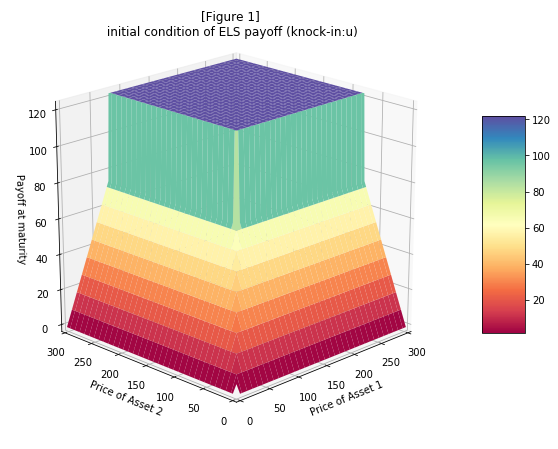

In [331]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

xx, yy = np.meshgrid(x, y)

fig = plt.figure(figsize=(10, 8))
ax = fig.gca(projection='3d') #3차원 전용 axes를 생성
surf = ax.plot_surface(xx, yy, u, cmap='Spectral', linewidth=0) #곡면 만들어줌
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(20, 225)
ax.set_xlabel('Price of Asset 1')
ax.set_ylabel('Price of Asset 2')
ax.set_zlabel('Payoff at maturity')
ax.set_xlim(0, L)
ax.set_ylim(0, L)
plt.title('[Figure 1]\n initial condition of ELS payoff (knock-in:u)')
plt.show()

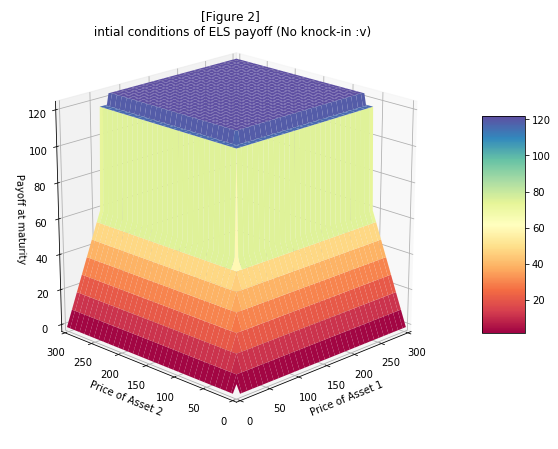

In [332]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

xx, yy = np.meshgrid(x, y)

fig = plt.figure(figsize=(10, 8))
ax = fig.gca(projection='3d') #3차원 전용 axes를 생성
surf = ax.plot_surface(xx, yy, v, cmap='Spectral', linewidth=0) #곡면 만들어줌
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(20, 225)
ax.set_xlabel('Price of Asset 1')
ax.set_ylabel('Price of Asset 2')
ax.set_zlabel('Payoff at maturity')
ax.set_xlim(0, L)
ax.set_ylim(0, L)
plt.title('[Figure 2]\n intial conditions of ELS payoff (No knock-in :v)')
plt.show()

In [333]:
Nt

360

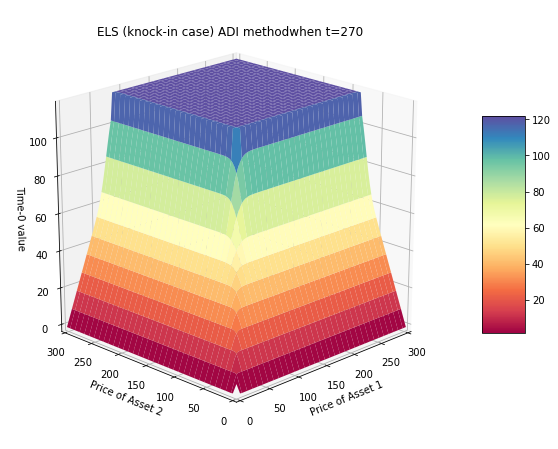

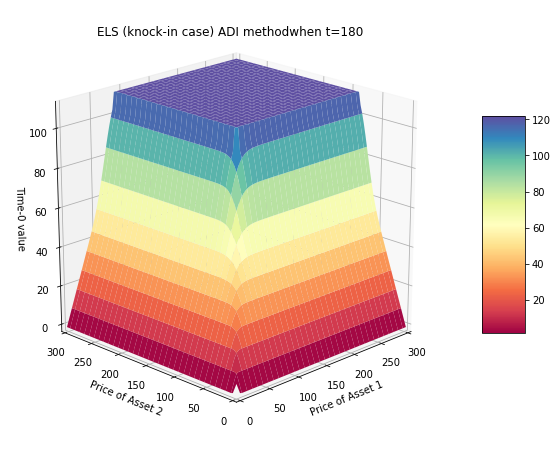

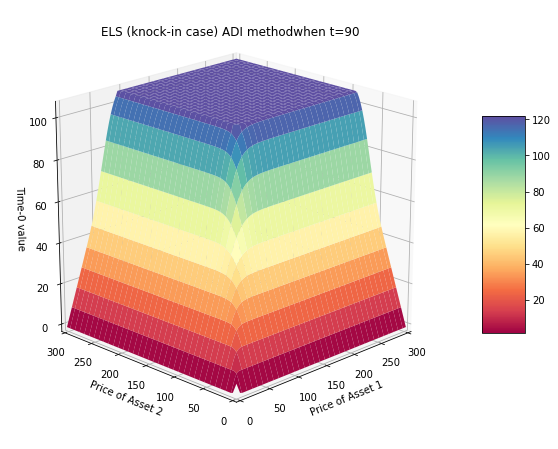

In [334]:
from TDMAsolver import TDMAsolver # reference: https://gist.github.com/cbellei/8ab3ab8551b8dfc8b081c518ccd9ada9
#이게 메인 타임 루프
#################### Time loop ####################
for k in range(Nt):
    #################### Step 1. The first stage of the ADI/OS algorithm ####################
    for j in range(1, Ny + 1):
        for i in range(1, Nx + 1):
            if method == 'ADI':
                #f[i-1] = 2*u[i, j]/dt + 1/2*(sig2*y[j])**2*(u[i,j+1]-2*u[i,j]+u[i,j-1])/(h**2) + r*y[j]*(u[i,j+1]-u[i,j])/h + rho*sig1*sig2*x[i]*y[i]*(u[i+1,j+1]+u[i-1,j-1]-u[i-1,j+1]-u[i+1,j-1])/(4*h**2) #for문 range는 1부터 시작이지만 f는 0부터 채워주려고 i-1
                f[i-1] = 2*(u[i,j]/dt+1/4*(sig2*y[j])**2*(u[i,j+1]-2*u[i,j]+u[i,j-1])/(h**2) + 1/2*r*y[j]*(u[i,j+1]-u[i,j])/h + 1/2*rho*sig1*sig2*x[i]*y[j]*(u[i+1,j+1]+u[i-1,j-1]-u[i-1,j+1]-u[i+1,j-1])/(4*h**2))
            elif method == 'OS':
                f[i-1] = 1/2*rho*sig1*sig2*x[i]*y[j]*(u[i+1,j+1]-u[i+1,j-1]-u[i-1,j+1]+u[i-1,j-1])/(4*h**2) + u[i,j]/dt
            else:
                raise ValueError
        
        # Tri-Diagonal Matrix Algorithm (Thomas algorithm)
        u2[1:-1, j] = TDMAsolver(a_x[1:], b_x, c_x[:-1], f)
        
    # Linear boundary condition
    u2[0, 1:-1] = 2 * u2[1, 1:-1] - u2[2, 1:-1]
    u2[-1, 1:-1] = 2 * u2[-2, 1:-1] - u2[-3, 1:-1]
    u2[:, 0] = 2 * u2[:, 1] - u2[:, 2]
    u2[:, -1] = 2 * u2[:, -2] - u2[:, -3]
    
    #################### Step 2. The second stage of the ADI/OS algorithm ####################
    for i in range(1, Nx + 1):
        for j in range(1, Ny + 1):
            if method == 'ADI':
                g[j-1] = 2*(u2[i,j]/dt + 1/4*(sig1*x[i])**2*(u2[i+1,j]-2*u2[i,j]+u2[i-1,j])/(h**2) + 1/2*r*x[i]*(u2[i+1,j]-u2[i,j])/h + 1/2*rho*sig1*sig2*x[i]*y[j]*(u2[i+1,j+1]+u2[i-1,j-1]-u2[i-1,j+1]-u2[i+1,j-1])/(4*h**2))
            elif method == 'OS':
                g[j-1] = 1/2*rho*sig1*sig2*x[i]*y[j]*(u2[i+1,j+1]-u2[i+1,j]-u2[i,j+1]+u2[i,j])/(4*h**2) + u2[i,j]/dt
            else:
                raise ValueError
        
        # Tri-Diagonal Matrix Algorithm (Thomas algorithm)
        u[i, 1:-1] = TDMAsolver(a_y[1:], b_y, c_y[:-1], g)
    
            
    # Linear boundary condition
    u[0, 1:-1] = 2 * u[1, 1:-1] - u[2, 1:-1]
    u[-1, 1:-1] = 2 * u[-2, 1:-1] - u[-3, 1:-1]
    u[:, 0] = 2 * u[:, 1] - u[:, 2]
    u[:, -1] = 2 * u[:, -2] - u[:, -3]
    
    if k==90:
        for i in range(len(x)):
            for j in range(len(y)):
                if x[i]>=ex_p[2]*K0 and y[j]>=ex_p[2]*K0:
                    u[i,j]=(1+ror[2])*F
        fig2 = plt.figure(figsize=(10, 8))
        ax2 = fig2.gca(projection='3d')
        surf2 = ax2.plot_surface(xx, yy, u, cmap='Spectral', linewidth=0)
        fig2.colorbar(surf, shrink=0.5, aspect=5)
        ax2.view_init(20, 225)
        ax2.set_xlabel('Price of Asset 1')
        ax2.set_ylabel('Price of Asset 2')
        ax2.set_zlabel('Time-0 value')
        ax2.set_xlim(0, L)
        ax2.set_ylim(0, L)
        plt.title('ELS (knock-in case) ' + method + ' method'+'when t=270')
        plt.show()
        
    elif k==180:
        for i in range(len(x)):
            for j in range(len(y)):
                if x[i]>=ex_p[1]*K0 and y[j]>=ex_p[1]*K0:
                    u[i,j]=(1+ror[1])*F
        fig2 = plt.figure(figsize=(10, 8))
        ax2 = fig2.gca(projection='3d')
        surf2 = ax2.plot_surface(xx, yy, u, cmap='Spectral', linewidth=0)
        fig2.colorbar(surf, shrink=0.5, aspect=5)
        ax2.view_init(20, 225)
        ax2.set_xlabel('Price of Asset 1')
        ax2.set_ylabel('Price of Asset 2')
        ax2.set_zlabel('Time-0 value')
        ax2.set_xlim(0, L)
        ax2.set_ylim(0, L)
        plt.title('ELS (knock-in case) ' + method + ' method'+'when t=180')
        plt.show()
        
    if k==270:
        for i in range(len(x)):
            for j in range(len(y)):
                if x[i]>=ex_p[0]*K0 and y[j]>=ex_p[0]*K0:
                    u[i,j]=(1+ror[0])*F
        fig2 = plt.figure(figsize=(10, 8))
        ax2 = fig2.gca(projection='3d')
        surf2 = ax2.plot_surface(xx, yy, u, cmap='Spectral', linewidth=0)
        fig2.colorbar(surf, shrink=0.5, aspect=5)
        ax2.view_init(20, 225)
        ax2.set_xlabel('Price of Asset 1')
        ax2.set_ylabel('Price of Asset 2')
        ax2.set_zlabel('Time-0 value')
        ax2.set_xlim(0, L)
        ax2.set_ylim(0, L)
        plt.title('ELS (knock-in case) ' + method + ' method'+'when t=90')
        plt.show()

In [335]:
print(u)

[[  3.71875359   1.37756343  -0.96362672 ...  -1.5         -1.5
   -1.5       ]
 [  1.37902009   1.45332398   1.52762786 ...   1.5          1.5
    1.5       ]
 [ -0.96071341   1.52908452   4.01888245 ...   4.5          4.5
    4.5       ]
 ...
 [ -1.5          1.5          4.5        ... 104.20397444 104.20397444
  104.20397444]
 [ -1.5          1.5          4.5        ... 104.20397444 104.20397444
  104.20397444]
 [ -1.5          1.5          4.5        ... 104.20397444 104.20397444
  104.20397444]]


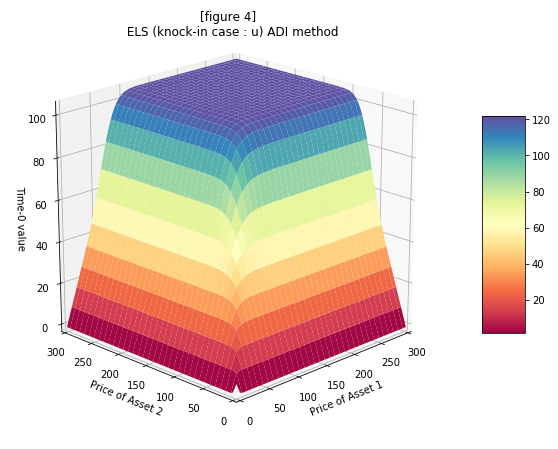

In [336]:
fig2 = plt.figure(figsize=(10, 8))
ax2 = fig2.gca(projection='3d')
surf2 = ax2.plot_surface(xx, yy, u, cmap='Spectral', linewidth=0)
fig2.colorbar(surf, shrink=0.5, aspect=5)
ax2.view_init(20, 225)
ax2.set_xlabel('Price of Asset 1')
ax2.set_ylabel('Price of Asset 2')
ax2.set_zlabel('Time-0 value')
ax2.set_xlim(0, L)
ax2.set_ylim(0, L)
plt.title('[figure 4] \n ELS (knock-in case : u) ' + method + ' method')
plt.show()

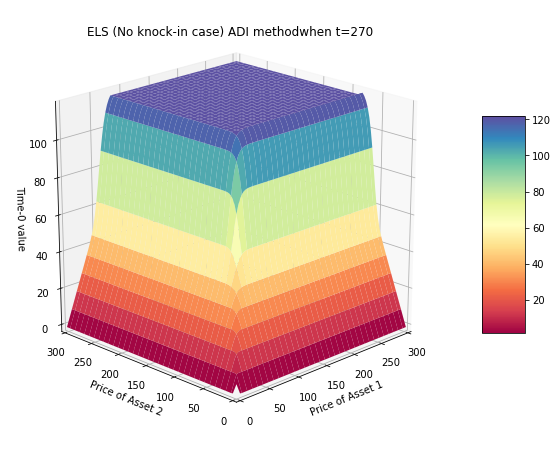

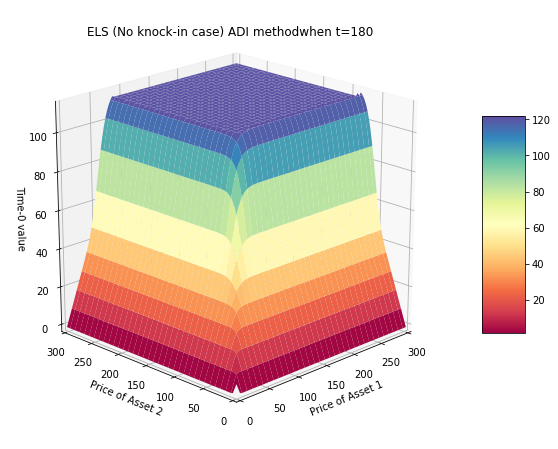

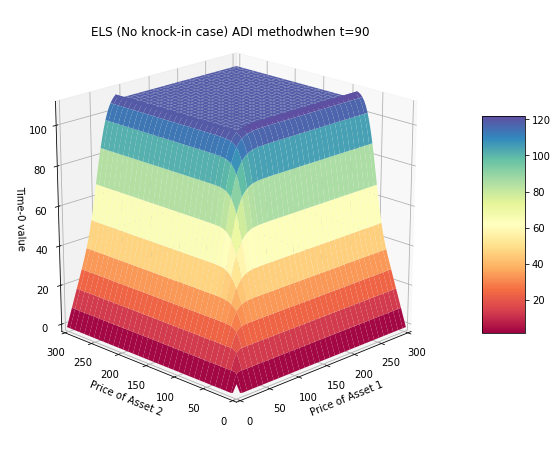

In [337]:
from TDMAsolver import TDMAsolver # reference: https://gist.github.com/cbellei/8ab3ab8551b8dfc8b081c518ccd9ada9
#이게 메인 타임 루프
#################### Time loop ####################
for k in range(Nt):
    #################### Step 1. The first stage of the ADI/OS algorithm ####################
    for j in range(1, Ny + 1):
        for i in range(1, Nx + 1):
            if method == 'ADI':
                #f[i-1] = 2*u[i, j]/dt + 1/2*(sig2*y[j])**2*(u[i,j+1]-2*u[i,j]+u[i,j-1])/(h**2) + r*y[j]*(u[i,j+1]-u[i,j])/h + rho*sig1*sig2*x[i]*y[i]*(u[i+1,j+1]+u[i-1,j-1]-u[i-1,j+1]-u[i+1,j-1])/(4*h**2) #for문 range는 1부터 시작이지만 f는 0부터 채워주려고 i-1
                f[i-1] = 2*(v[i,j]/dt+1/4*(sig2*y[j])**2*(v[i,j+1]-2*v[i,j]+v[i,j-1])/(h**2) + 1/2*r*y[j]*(v[i,j+1]-v[i,j])/h + 1/2*rho*sig1*sig2*x[i]*y[j]*(v[i+1,j+1]+v[i-1,j-1]-v[i-1,j+1]-v[i+1,j-1])/(4*h**2))
            elif method == 'OS':
                f[i-1] = 1/2*rho*sig1*sig2*x[i]*y[j]*(v[i+1,j+1]-v[i+1,j-1]-v[i-1,j+1]+v[i-1,j-1])/(4*h**2) + v[i,j]/dt
            else:
                raise ValueError
        
        # Tri-Diagonal Matrix Algorithm (Thomas algorithm)
        v2[1:-1, j] = TDMAsolver(a_x[1:], b_x, c_x[:-1], f)
        
    # Linear boundary condition
    v2[0, 1:-1] = 2 * v2[1, 1:-1] - v2[2, 1:-1]
    v2[-1, 1:-1] = 2 * v2[-2, 1:-1] - v2[-3, 1:-1]
    v2[:, 0] = 2 * v2[:, 1] - v2[:, 2]
    v2[:, -1] = 2 * v2[:, -2] - v2[:, -3]
    
    #################### Step 2. The second stage of the ADI/OS algorithm ####################
    for i in range(1, Nx + 1):
        for j in range(1, Ny + 1):
            if method == 'ADI':
                g[j-1] = 2*(v2[i,j]/dt + 1/4*(sig1*x[i])**2*(v2[i+1,j]-2*v2[i,j]+v2[i-1,j])/(h**2) + 1/2*r*x[i]*(v2[i+1,j]-v2[i,j])/h + 1/2*rho*sig1*sig2*x[i]*y[j]*(v2[i+1,j+1]+v2[i-1,j-1]-v2[i-1,j+1]-v2[i+1,j-1])/(4*h**2))
            elif method == 'OS':
                g[j-1] = 1/2*rho*sig1*sig2*x[i]*y[j]*(v2[i+1,j+1]-v2[i+1,j]-v2[i,j+1]+v2[i,j])/(4*h**2) + v2[i,j]/dt
            else:
                raise ValueError
        
        # Tri-Diagonal Matrix Algorithm (Thomas algorithm)
        v[i, 1:-1] = TDMAsolver(a_y[1:], b_y, c_y[:-1], g)
    
            
    # Linear boundary condition
    v[0, 1:-1] = 2 * v[1, 1:-1] - v[2, 1:-1]
    v[-1, 1:-1] = 2 * v[-2, 1:-1] - v[-3, 1:-1]
    v[:, 0] = 2 * v[:, 1] - v[:, 2]
    v[:, -1] = 2 * v[:, -2] - v[:, -3]
    
    if k==90:
        for i in range(len(x)):
            for j in range(len(y)):
                if x[i]>=ex_p[2]*K0 and y[j]>=ex_p[2]*K0:
                    v[i,j]=(1+ror[2])*F
        fig2 = plt.figure(figsize=(10, 8))
        ax2 = fig2.gca(projection='3d')
        surf2 = ax2.plot_surface(xx, yy, v, cmap='Spectral', linewidth=0)
        fig2.colorbar(surf, shrink=0.5, aspect=5)
        ax2.view_init(20, 225)
        ax2.set_xlabel('Price of Asset 1')
        ax2.set_ylabel('Price of Asset 2')
        ax2.set_zlabel('Time-0 value')
        ax2.set_xlim(0, L)
        ax2.set_ylim(0, L)
        plt.title('ELS (No knock-in case) ' + method + ' method'+'when t=270')
        plt.show()
        
    elif k==180:
        for i in range(len(x)):
            for j in range(len(y)):
                if x[i]>=ex_p[1]*K0 and y[j]>=ex_p[1]*K0:
                    v[i,j]=(1+ror[1])*F
        fig2 = plt.figure(figsize=(10, 8))
        ax2 = fig2.gca(projection='3d')
        surf2 = ax2.plot_surface(xx, yy, v, cmap='Spectral', linewidth=0)
        fig2.colorbar(surf, shrink=0.5, aspect=5)
        ax2.view_init(20, 225)
        ax2.set_xlabel('Price of Asset 1')
        ax2.set_ylabel('Price of Asset 2')
        ax2.set_zlabel('Time-0 value')
        ax2.set_xlim(0, L)
        ax2.set_ylim(0, L)
        plt.title('ELS (No knock-in case) ' + method + ' method'+'when t=180')
        plt.show()
        
    if k==270:
        for i in range(len(x)):
            for j in range(len(y)):
                if x[i]>=ex_p[0]*K0 and y[j]>=ex_p[0]*K0:
                    v[i,j]=(1+ror[0])*F
        fig2 = plt.figure(figsize=(10, 8))
        ax2 = fig2.gca(projection='3d')
        surf2 = ax2.plot_surface(xx, yy, v, cmap='Spectral', linewidth=0)
        fig2.colorbar(surf, shrink=0.5, aspect=5)
        ax2.view_init(20, 225)
        ax2.set_xlabel('Price of Asset 1')
        ax2.set_ylabel('Price of Asset 2')
        ax2.set_zlabel('Time-0 value')
        ax2.set_xlim(0, L)
        ax2.set_ylim(0, L)
        plt.title('ELS (No knock-in case) ' + method + ' method'+'when t=90')
        plt.show()

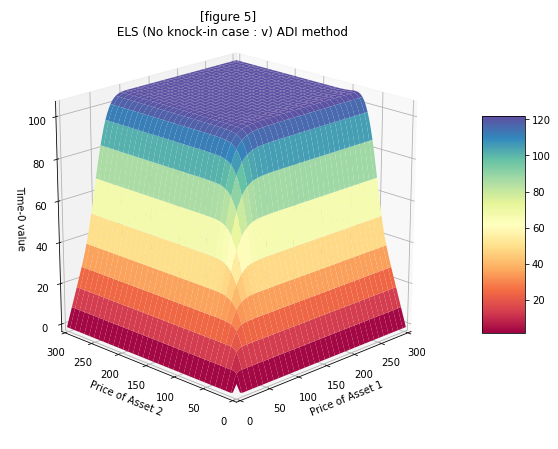

In [338]:
fig2 = plt.figure(figsize=(10, 8))
ax2 = fig2.gca(projection='3d')
surf2 = ax2.plot_surface(xx, yy, v, cmap='Spectral', linewidth=0)
fig2.colorbar(surf, shrink=0.5, aspect=5)
ax2.view_init(20, 225)
ax2.set_xlabel('Price of Asset 1')
ax2.set_ylabel('Price of Asset 2')
ax2.set_zlabel('Time-0 value')
ax2.set_xlim(0, L)
ax2.set_ylim(0, L)
plt.title('[figure 5] \n ELS (No knock-in case : v) ' + method + ' method')
plt.show()

In [343]:
############ Probability of knock-in #####################
import numpy as np
import scipy.stats
n_monte=20000
x=np.zeros(shape=Nt+1)
y=np.zeros(shape=Nt+1)
#s=np.zeros(shape=Nt+1)
x[0]=K0
y[0]=K0
count=0
Z_x=np.random.standard_normal()
Z_y=rho*Z_x+np.sqrt(1-rho**2)*np.random.standard_normal()
for i in range(n_monte):
        for j in range(Nt):
            Z_x=np.random.standard_normal()
            Z_y=rho*Z_x+np.sqrt(1-rho**2)*np.random.standard_normal()
            x[j+1] = x[j] * np.exp((r - 0.5 * sig1**2) * dt + sig1 * np.sqrt(dt) * Z_x)
            y[j+1] = y[j] * np.exp((r - 0.5 * sig2**2) * dt + sig2 * np.sqrt(dt) * Z_y)
        X=np.min(x)
        Y=np.min(y)
        s=min(X,Y)
        if s<=D:
            count+=1
print(count)

2057


In [344]:
p=(count/n_monte)*100 #probability of knock-in

In [345]:
p

10.285

array([[  3.71875359,   1.37756343,  -0.96362672, ...,  -1.5       ,
         -1.5       ,  -1.5       ],
       [  1.37902009,   1.45332398,   1.52762786, ...,   1.5       ,
          1.5       ,   1.5       ],
       [ -0.96071341,   1.52908452,   4.01888245, ...,   4.5       ,
          4.5       ,   4.5       ],
       ...,
       [ -1.50000001,   1.5       ,   4.50000001, ..., 104.20397444,
        104.20397444, 104.20397444],
       [ -1.50000001,   1.5       ,   4.50000001, ..., 104.20397444,
        104.20397444, 104.20397444],
       [ -1.50000001,   1.5       ,   4.50000001, ..., 104.20397444,
        104.20397444, 104.20397444]])

In [346]:
############### final value of ELS ################
value=p/100*u+(1-p/100)*v

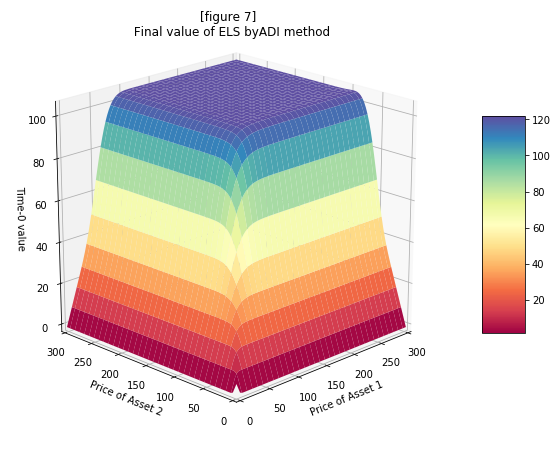

In [347]:
fig2 = plt.figure(figsize=(10, 8))
ax2 = fig2.gca(projection='3d')
surf2 = ax2.plot_surface(xx, yy, value, cmap='Spectral', linewidth=0)
fig2.colorbar(surf, shrink=0.5, aspect=5)
ax2.view_init(20, 225)
ax2.set_xlabel('Price of Asset 1')
ax2.set_ylabel('Price of Asset 2')
ax2.set_zlabel('Time-0 value')
ax2.set_xlim(0, L)
ax2.set_ylim(0, L)
plt.title('[figure 7] \n Final value of ELS by' + method + ' method')
plt.show()